Import of libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt

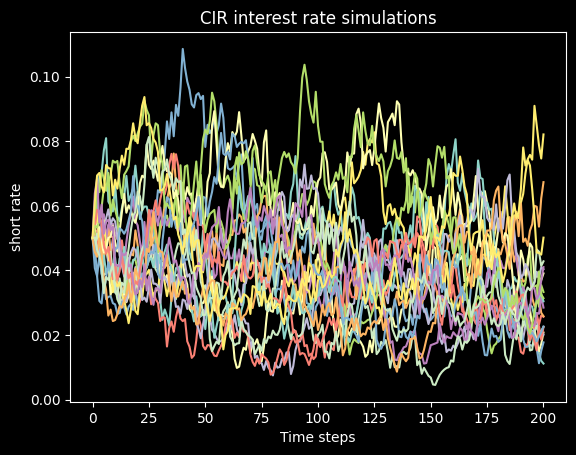

In [8]:
# create a CIR path where CIR is defined by df = kappa(theta-r)dt+ sigma*sqrt(r)*dW

def cir_paths (r0, kappa, theta, sigma, T, steps, n_paths):
    dt = T/steps
    rates = np.zeros((n_paths, steps+1))
    rates [:,0] = r0

    for t in range(steps):
        z = np.random.normal(size=n_paths)
        sqrt_r = np.sqrt(np.maximum(rates[:,t],0))

        dr = kappa*(theta-rates[:,t])*dt+sigma*sqrt_r*np.sqrt(dt)*z
        rates[:,t+1] = rates[:,t] + dr

        # keep rates non negative
        rates[:,t+1] = np.maximum(rates[:,t+1],0)

    return rates


paths = cir_paths(
    r0=0.05,
    kappa=0.6,
    theta=0.04,
    sigma=0.1,
    T=10,
    steps=200,
    n_paths=20
)

plt.plot(paths.T)
plt.title("CIR interest rate simulations")
plt.xlabel("Time steps")
plt.ylabel("short rate")
plt.style.use('dark_background')
plt.show()


CIR Closed Form

In [10]:
# Closed form CIR

def cir_zero_bond(r0, kappa, theta, sigma, T):

    gamma = np.sqrt(kappa**2 + 2*sigma**2)

    B = (2*(np.exp(gamma*T)-1)) / (
        (gamma+kappa)*(np.exp(gamma*T)-1) + 2*gamma
    )

    A = (
        (2*gamma*np.exp((kappa+gamma)*T/2)) /
        ((gamma+kappa)*(np.exp(gamma*T)-1)+2*gamma)
    )**(2*kappa*theta/sigma**2)

    return A*np.exp(-B*r0)

Monte Carlo Simulation

In [11]:
def cir_monte_carlo(r0, kappa, theta, sigma, T, steps, n_paths):

    paths = cir_paths(r0, kappa, theta, sigma, T, steps, n_paths)

    dt = T/steps

    # integrate r over time
    integrals = np.sum(paths[:,:-1]*dt, axis=1)

    discounts = np.exp(-integrals)

    return np.mean(discounts)

CIR vs MC

In [12]:
r0=0.05
kappa=0.6
theta=0.04
sigma=0.1
T=5

analytic = cir_zero_bond(r0,kappa,theta,sigma,T)
mc = cir_monte_carlo(r0,kappa,theta,sigma,T,steps=400,n_paths=50000)

print("Analytical price:", analytic)
print("Monte Carlo:", mc)

Analytical price: 0.8071729054566364
Monte Carlo: 0.8072616564894723


Bond bootstrapping

In [13]:
# example of market bond 
maturities = np.array([0.5, 1, 2, 3, 5])
yields = np.array([0.02, 0.022, 0.025, 0.027, 0.03])

discount_factors = np.exp(-yields*maturities)

print("Maturities: ", maturities)
print("Discounts: ", discount_factors)

Maturities:  [0.5 1.  2.  3.  5. ]
Discounts:  [0.99004983 0.97824024 0.95122942 0.92219369 0.86070798]


Define error function

In [14]:
from scipy.optimize import minimize

def cir_error(params, maturities, discounts_market):
    r0, kappa, theta, sigma = params
    discounts_model = np.array([cir_zero_bond(r0, kappa, theta, sigma, T) for T in maturities])
    return np.sum((discounts_model - discounts_market)**2)

Calibrate CIR Parameters

In [15]:
# parameters guesses for r0, kappa, theta, sigma and T
x0 = [0.03, 0.5, 0.03, 0.05]

# bounds to ensure that the parameters stay positive in the process of calibration
bounds = [(0,0.2), (0,2), (0,0.2), (0,0.2)]

res = minimize(cir_error, x0, args=(maturities, discount_factors), bounds=bounds)
r0_fit, kappa_fit, theta_fit, sigma_fit = res.x

print("Fitted CIR parameters:")
print("r0:", r0_fit)
print("kappa:", kappa_fit)
print("theta:", theta_fit)
print("sigma:", sigma_fit)


Fitted CIR parameters:
r0: 0.01781711054146307
kappa: 0.500097674177645
theta: 0.03713657930183759
sigma: 0.049953045282279215


CIR Model Implied Curve vs Market Curve

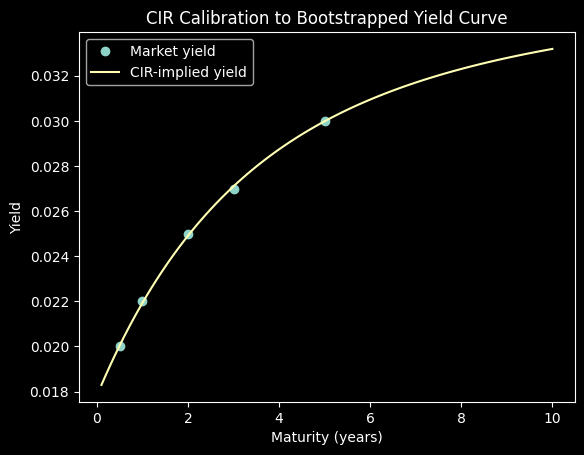

In [16]:
Ts = np.linspace(0.1, 10, 100)
discounts_cir = [cir_zero_bond(r0_fit, kappa_fit, theta_fit, sigma_fit, T) for T in Ts]
yields_cir = [-np.log(P)/T for P,T in zip(discounts_cir, Ts)]

plt.plot(maturities, yields, 'o', label="Market yield")
plt.plot(Ts, yields_cir, label="CIR-implied yield")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield")
plt.title("CIR Calibration to Bootstrapped Yield Curve")
plt.legend()
plt.show()